# Прогнозирование вероятности оттока пользователей для фитнес-центров

## Введение

Для борьбы с оттоком клиентов фитнес-клуб «Культурист-датасаентист» решил разработать стратегию взаимодействия с клиентами на основе данных уже имеющихся анкет клиентов.<br>
<br>Наша задача состоит в том, что бы провести анализ и подготовить план действий по удержанию клиентов нашего фитнес-клуба.

## Загрузка и просмотр данных

In [ ]:
#импорт библиотек и настройка стидей графиков
import pandas as pd
import seaborn as sns
import numpy as np
import pylab
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

import plotly.io as pio
pio.renderers.default = "png"


plt.style.use('ggplot')

In [ ]:
# открытие и просмотр датасета
df= pd.read_csv('/datasets/gym_churn.csv')
df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В предоставленном датафрейме, мы можем увидеть следующие данные:<br>

**Данные клиента за предыдущий до проверки факта оттока месяц:**
 - `gender` — пол;
 - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
 - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент  -  в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - `Phone` — наличие контактного телефона;
 - `Age` — возраст;
 - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).<br>

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
 - `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
 - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
 - `Group_visits` — факт посещения групповых занятий;
 - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
 - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
 - `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
 - `Churn` — факт оттока в текущем месяце.
 <br> Для удобства работы, приведем названия столбцов к нижнему регистру.

In [ ]:
#приведение названий колонок к нижнему регистру
df.columns = map(str.lower, df.columns)
df.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Иследовательский анализ данных (EDA)

Рассмотрим и оценим имеющиесу у нас данные.
<br> Выведем  информацио о размере датасета и общую информацию имеющихся данных.

In [ ]:
#вывод иинформации о размере датасета
print(df.shape)
print(df.info())

(4000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-n

Итак, у нас 400 строк и 14 столбцов в датафрейме. Пропуски, как мы видим, отсутствуют.
<br>Проверим наличие дубликатов в таблице.

In [ ]:
df.duplicated().sum()

0

Дубликаты так же отсутствуют.
<br> Заменим некоторые типы данных для дальнейшего удобства в работе.

In [ ]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')
df[['near_location', 'partner', 'promo_friends','group_visits', 'churn','phone','gender']] = df[['near_location', 'partner', 'promo_friends','group_visits', 'churn', 'phone','gender']].astype('bool')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   bool   
 1   near_location                      4000 non-null   bool   
 2   partner                            4000 non-null   bool   
 3   promo_friends                      4000 non-null   bool   
 4   phone                              4000 non-null   bool   
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   bool   
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Рассмотрим  средние значения и стандартные отклонения с помощью метода `describe()`

In [ ]:
df.describe()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


Средние значения признаков примерно на одном уровне с медианными значениями, как и стандартное отклонение.<br> Выбросов в данных не видно.

### Cредние значения признаков в группах оставшихся и ушедших клиентов 

Рассмотрим таблицу со средними значениями признаков в разбивке на ушедших и оставшихся клиентов фитнес-клуба. 

In [ ]:
#средние значения признаков по группам оставшихся и ушедших клиентов
df.groupby('churn').mean()


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
False,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
True,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Пройдемся по порядку признаков полученных с помощью `groupby()`:
 - gender: средние значения по полу клиентов одинаковы, поэтому можно сказать, что он не влияет на отток пользователей
 - near_location:  в обоих случаях клиентов, которые живут или работают рядом с клубом больше, чем других. Однако, те что живут или работают не рядом с клубом уходят чаще. Хотя разница средних значений и не столь высока
 - partner: отток среди клиентов, которые являются мотрудниками партнеров клуба - меньше
 - promo_friends: Клиентов, которые пришли по акции "Приведи друга" не так много, однако в отток  в два раза чаще попадаю те, кто пришел  вклуб без друзей.
 - phone: Почти у всех есть контактный телефон и этот признак ни как не влияется на отток клиентов фитнес-клуба
 - contract_period: логично, что чем длинее договор, тем меньше отток, т.к. многие покупают абонемент всего на месяц.
 - group_visits: групповые занятия положительно влияют на клиентов и отток у них меньше. Многие и ходят в зал только ради них.
 - age: по средним значениям возможно и можно сказать, что возраст положительно влияет на оставшихся в клубе клиентов, но разница в среднем возрасте не так уж и велика.
 - avg_additional_charges_total: суммарные затраты на доп. услуги клуба, хоть и не сильно, но все же положительно влияют на наших клиентов.
 - month_to_end_contract: как и в случае с contract_period, чем длинее остаток договора, тем меньше отток.
 - lifetime: Этот признак очень положительно влияет на наших клиентов. Чем долше человек пользуется услугами клуба, тем меньше вероятность, что он его бросит.
 - avg_class_frequency_total: клиенты, которые находятся в группе оттока посещали клуб реже, чем оставшиеся с нами клиенты.
 - avg_class_frequency_current_month: ситуация с данным признаком имеет такую же логику как и предыдущий признак.


### Cтолбчатые гистограммы признаков для двух групп пользователей, тех кто ушел и тех, кто остался

Построим столбчатые гистограммы признаков по группе ушедших и по группе оставшихся клиентов.
<br>Для начала разделим признаки на булевые и на числовые.

In [ ]:
#переменная с булевыми признаками
bull = ['gender','near_location', 'partner', 'promo_friends','phone','group_visits']

#переменная с числовыми признаками
integer = ['lifetime','contract_period','age','month_to_end_contract','avg_additional_charges_total','avg_class_frequency_total','avg_class_frequency_current_month']

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



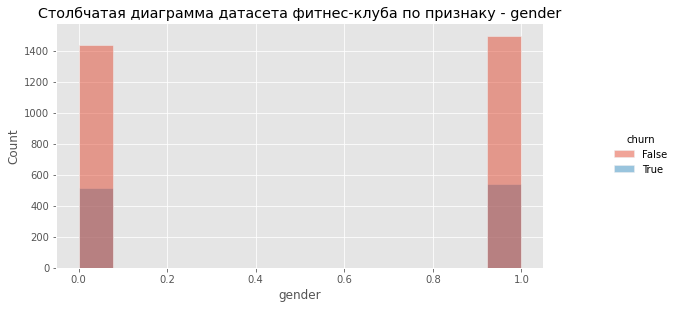

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



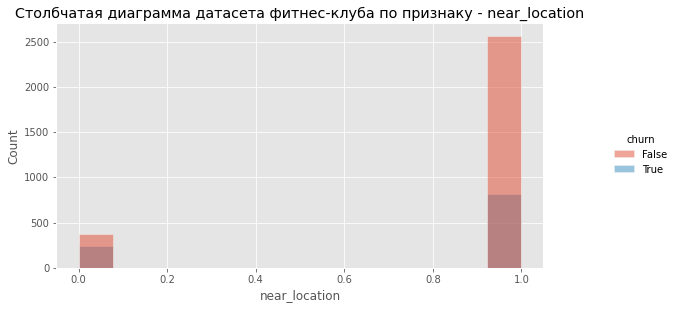

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



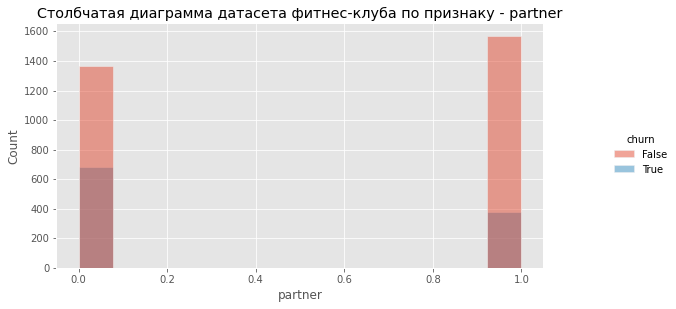

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



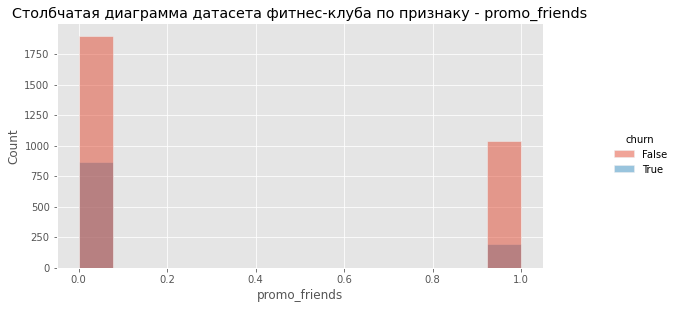

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



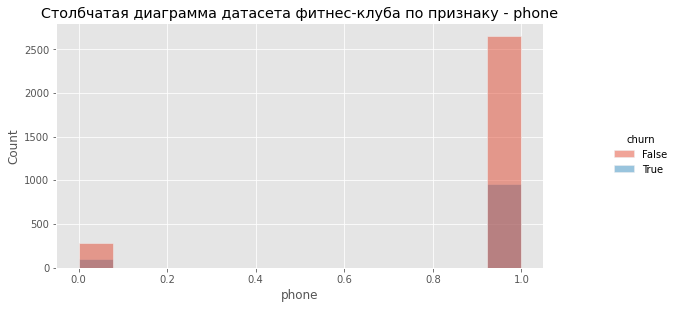

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.

<__array_function__ internals>:5: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



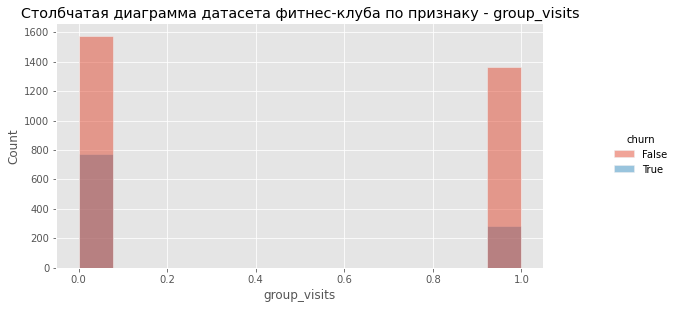

In [ ]:
#построение гистограмы булевых признаков

for col in bull:
    
    h = sns.displot(data=df,x=col,hue='churn')
    h.fig.set_figwidth(10)
    h.fig.set_figheight(4)
    plt.title(f'Столбчатая диаграмма датасета фитнес-клуба по признаку - {col}')
    
    plt.show()

Итак, на гистограммах булевых признаков мы видим, что 
- пол не влияет на отток, а количество женщин и мужчин примерно одинаково.
- Клиентов, живущих или работающих поблизости намного больше.
- Сотрудников компаний-партнеров больше, и доля оттока по ним меньше.
- Участников акции "Приведи друга" не так много, но отток у них меньше. С друзьями качаться веселее.
- Тех, у кого нет контактных телефонов почти нет, а как показали нам ранее средние показатели, на отток этот показатель не влияет.
- Тех, кто ходил на групповые занятия меньше, но и доля оттока по ним меньше.
<br><br>Построим так же гистограммы для числовых признаков


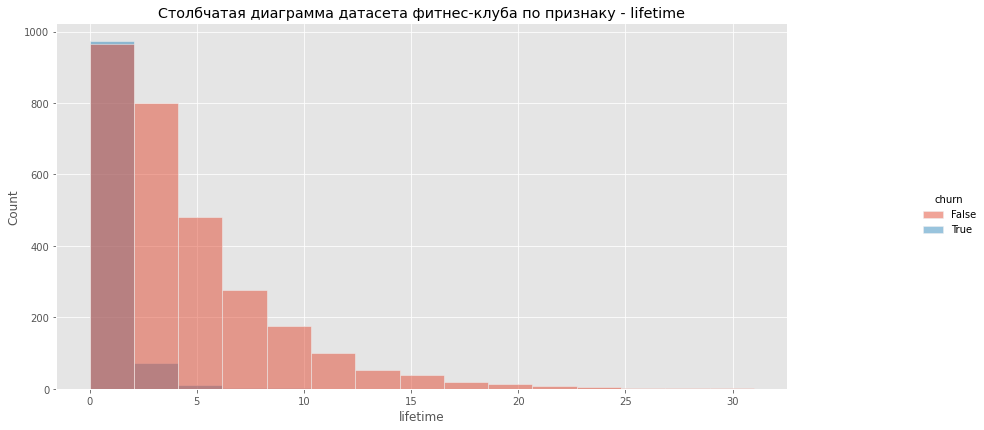

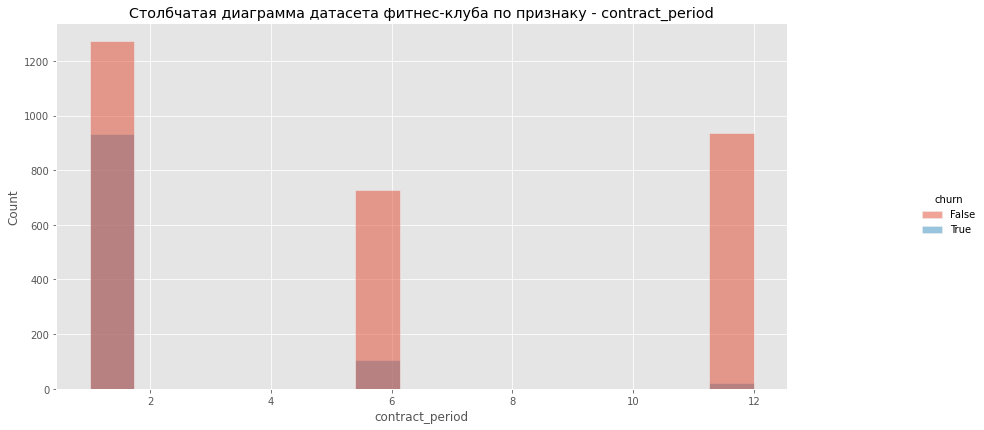

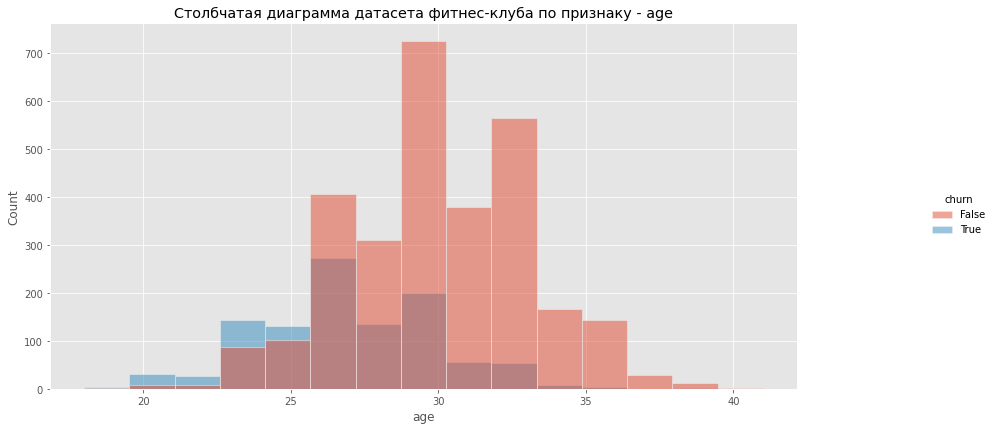

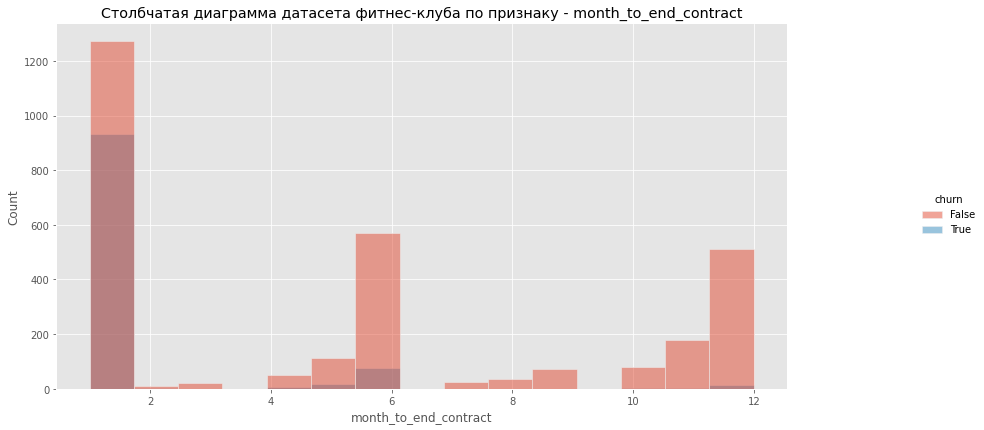

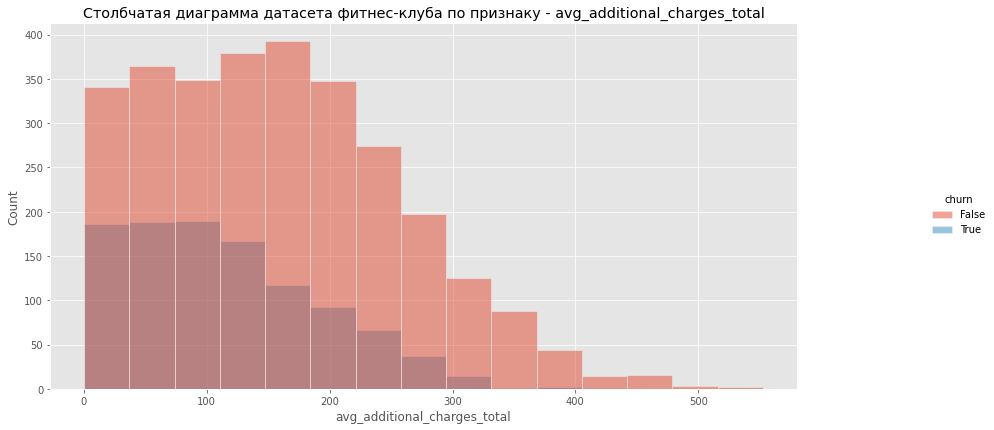

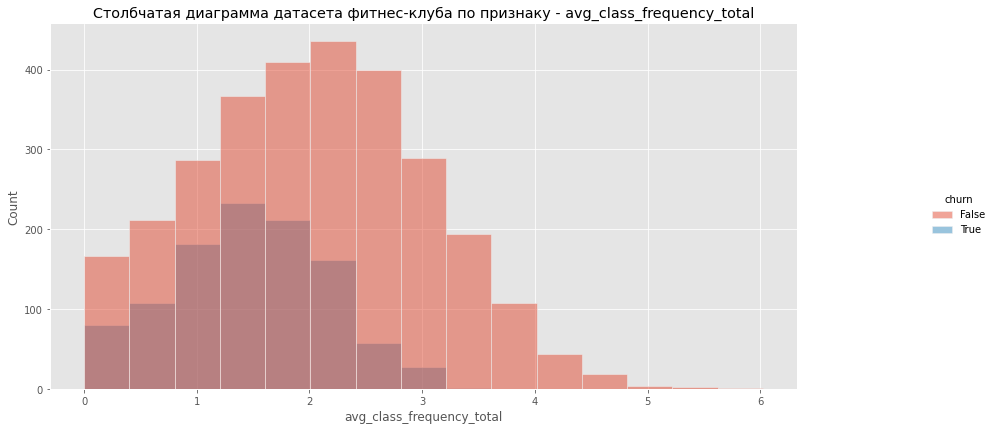

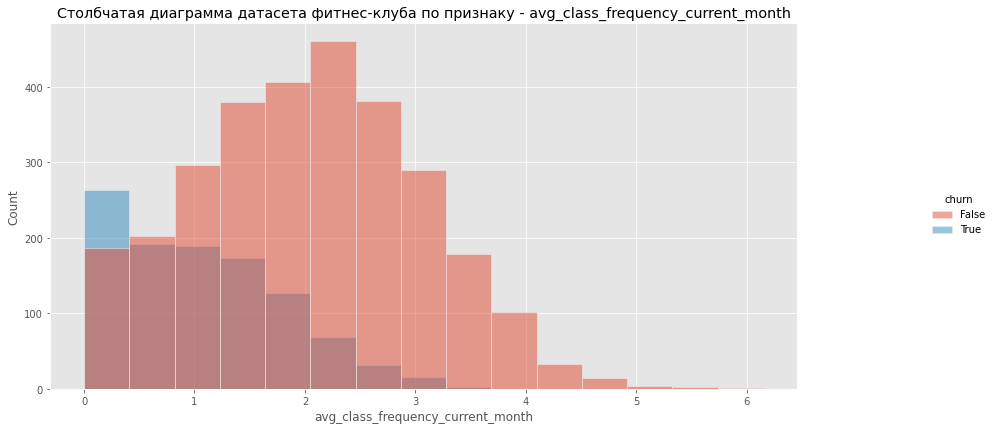

In [ ]:
for col in integer:
    
    
    h = sns.displot(data=df,x=col,hue='churn',bins=15)
    h.fig.set_figwidth(15)
    h.fig.set_figheight(6)
    plt.title(f'Столбчатая диаграмма датасета фитнес-клуба по признаку - {col}')
    
    plt.show()

- Основной отток приходится на первый месяц посещений
- Так же, больший отток клиентов с периодом абонемента - 1 месяц, так же самое большое количество клиентов приобрели абонемент только на 1 месяц.
- Больше всего клиентов 29-30 лет. А вот отток в основном 26 лет, а второй пик так же на 29-30 года, что примечально оттока помле 35 лет почти нет.
- Время до окончания контракта влияет на отток, что логично, чем менее длителен абонемент, тем больше отток. 
- Чем больше клиент тратит денег на доп. услуги, тем меньше отток, но и количество таких клиентов идут на убыль с повышением общей суммы затраченого.
- Клиенты, которые посещают спорт-клуб 0-2 раза в неделю доля оттока примерно одинакова, она снижается при переходе с 2 раз в неделю до 3. А у клиентов, что ходят 3 раза и больше отток почти не наблюдается.
- Ситуация по посещениям в неделю за последний месяц, напоменает предыдущий пункт, более 3х посещений в неделю и отток отсутствует, однако доля оттока с 0 до 3 посещений тут идет по ниспадающей. Т.е. чем меньше посещений, тем больше доля оттока клиентов.

### Матрица корреляций

С помощью метода `.corr()` построим матрицу корреляций и визуализировав ее посмотрим есть ли зависимости между признаками.

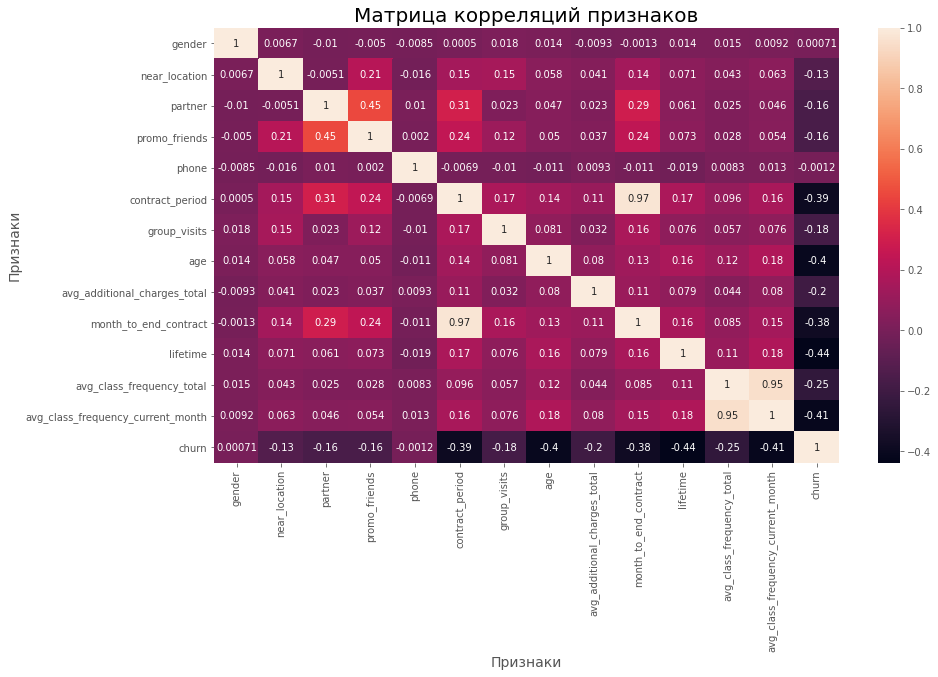

In [ ]:
#построением матрици корреляций и визуализация heatmap
corr = df.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr, annot = True, square=False)
plt.title('Матрица корреляций признаков', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14) 
plt.ylabel('Признаки', fontsize = 14) 
plt.show()

Самая большая зависимость факт оттока в текущем месяце(churn) наблюдается у признаков `lifetime (-0,44)`, `avg_class_frequency_current_month(-0,41)`, `age(-0,4)`, `contract_period(-0,39)` и `month_to_end_contract(-0,38)`. Связь ни одного из признаков не привысила коэффициент 0,5. <br> На тепловой карте мы можем наблюдать несколько мультиколлинеарных признака это `contract_period` и `month_to_end_contract`, а так же `avg_class_frequency_total` и `avg_class_frequency_current_month`/

## Построение модели прогнозирования оттока клиентов

### Разбивка данных на обучающую и валидационную выборки

Для построения модели бинарной классификации клиентов разобьем наши данные на обучающию и валидационную выборки.

In [ ]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn'] 

In [ ]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Обучение модели двумя способами

Для обучения выборки будем использовать две модели:
- случайный лес(*RandomForestClassifier*)
- логистическая регрессия(*LogisticRegression*)


In [ ]:
#список моделей
models = [RandomForestClassifier(random_state=0),
    LogisticRegression(random_state=0,solver='liblinear')]
#функция обучения и расчета метрик: accuracy, precision и recall
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)# ваш код здесь
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy =',acc.round(3))
    precision = precision_score(y_test, y_pred).round(3)
    print('Precision =', precision)
    recall = recall_score(y_test, y_pred).round(3)
    print('Recall =', recall, '\n')

In [ ]:
#цикл для вывода метрик по списку моделей
for i in models:
    if i == models[0]:
        print('Модель прогнозирования - Случайный Лес')
    else:
        print('Модель прогнозирования - Логистическая регрессия')
    
    make_prediction(
        m=i,
        X_train = X_train,
        y_train = y_train,
        X_test = X_test,
        y_test = y_test,
    )

Модель прогнозирования - Случайный Лес
Accuracy = 0.916
Precision = 0.839
Recall = 0.818 

Модель прогнозирования - Логистическая регрессия
Accuracy = 0.926
Precision = 0.864
Recall = 0.833 



По всем метрикам `Логистическая регрессия` показала себя немного лучше чем, модель `Случайный Лес`.

## Кластеризация клиентов

### Стандартизация данных 

Перед тем, как провести кластеризацию клиентов, приведем признаки к  единому масштабу знакомыми методами нормализации и стандартизации

In [ ]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler() 
# обучаем нормализатор и преобразуем набор данных
x_sc = scaler.fit_transform(X) 
x_sc[:5]

array([[ 0.97970588,  0.42788074,  1.02686062,  1.49716101, -3.05985201,
         0.28989014,  1.19403206, -0.0565538 , -1.37753121,  0.16160501,
        -0.19332863, -1.91191971, -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , -0.66793083,  0.32681319,
         1.60882159,  1.19403206,  0.55732732, -0.35021325,  1.83194105,
         0.87368001,  0.04517569,  0.1360137 ],
       [-1.0207145 ,  0.42788074,  1.02686062, -0.66793083,  0.32681319,
        -0.8092194 , -0.83749845, -0.36349436, -0.1815923 , -0.79287273,
        -0.46008079, -0.02049263, -0.02901851],
       [-1.0207145 ,  0.42788074,  1.02686062,  1.49716101,  0.32681319,
         1.60882159,  1.19403206,  1.17120844, -0.87472237,  1.83194105,
        -0.46008079,  1.36465509,  1.51045005],
       [ 0.97970588,  0.42788074,  1.02686062,  1.49716101,  0.32681319,
        -0.8092194 , -0.83749845, -0.97737548,  0.5336998 , -0.79287273,
        -0.19332863, -0.78707638, -0.61454183]])

Построим матрицу расстояний на стандартизованной матрице признаков.

In [ ]:
#построение матрицы расстояний
link = linkage(x_sc, method = 'ward')
link 

array([[9.70000000e+01, 3.22200000e+03, 1.00990653e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.22634574e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.28123291e-01, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.38725499e+01, 2.65600000e+03],
       [7.98800000e+03, 7.99600000e+03, 8.89563592e+01, 3.03400000e+03],
       [7.99200000e+03, 7.99700000e+03, 1.04627601e+02, 4.00000000e+03]])

Визуализируем дендрограмму.

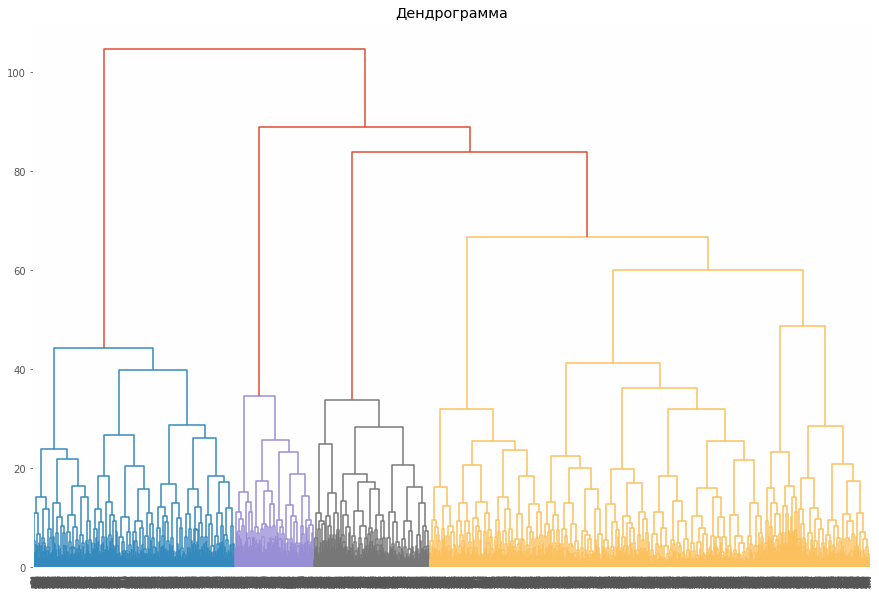

In [ ]:
#создание дендрограммы
plt.figure(figsize=(15, 10))  
dendrogram(link, orientation='top')
plt.title('Дендрограмма')
plt.show() 

По дендрограмме можно выделить 4 основных кластера клиентов.

### Обучение модели кластеризации на основании алгоритма K-Means

С помощью алгоритма K-Means. Так как данный алгоритм подуразумевает, что число кластеров уже известно, то возьмем за это число 5, на один кластер больше, чем показала нам ранее дендрограмма.

In [ ]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0)
# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(x_sc)  

In [ ]:
# сохраняем метки кластера в поле датасета 
df['cluster_km'] = labels
#вывод первых 5 строк датасета
df.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster_km
0,True,True,True,True,False,6,True,29,14.227470,5,3,0.020398,0.000000,False,1
1,False,True,False,False,True,12,True,31,113.202938,12,7,1.922936,1.910244,False,0
2,False,True,True,False,True,1,False,28,129.448479,1,2,1.859098,1.736502,False,3
3,False,True,True,True,True,12,True,33,62.669863,12,2,3.205633,3.357215,False,0
4,True,True,True,True,True,1,False,26,198.362265,1,3,1.113884,1.120078,False,3


Посмотрим на количество клиентов в каждом полученном кластере

In [ ]:
df.groupby(['cluster_km'])['gender'].count()

cluster_km
0    1010
1     385
2     505
3    1262
4     838
Name: gender, dtype: int64

Больше всего клиентов в кластере 3 и кластере 0, самый маленький кластер - 1.
<br> Рассмотрим средние значения признаков по кластерам

In [ ]:
#группировка по кластерам с выводом среднего значения признаков
df.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


**Кластер 0** - самый маленький отток, в основном живут рядом с фитнес-клубом. У них самый длиный период абонемента и не самый низкий лайфтайм. Посещений в неделю, в среднем, около 2. Многие из них пришли по партнерской программе и еще и с друзьями.<br>
**Кластер 1** - приличный отток клиентов. Основная часть клиентов проживает или работает рядом с фитнес-клубом. Нет контактных телефонов.<br>
**Кластер 2** - отток около 45%, проживают или работают далеко от клуба. Посещений в неделю мало, оно и понятно - далеко. Друзей в клубе так же почти ни у кого нет.<br>
**Кластер 3** - самый большой отток и самое большое количество клиентов. Все проживают или работают рядом с фитнес-клубом. Самый маленький лайфтайм и период контракта. Посещение в неделю 1 и с течением времени идет на спад. Видимо, это клиенты, которые решили начать с понедельника новую жизнь, но на долго их не хватило.<br>
**Кластер 4** -довольно маленький отток. Основная часть клиентов живет или работает не далеко от клуба. Самый большой лайфтайм. Период контракта в среднем 2,5 месяца.А вот посещений в неделю ближе к 3. Похоже, что это довольно мобильные и накачаные ребята.



### Построение распределения признаков для кластеров

Построим распределление для кластеров по ghbpyfrfv

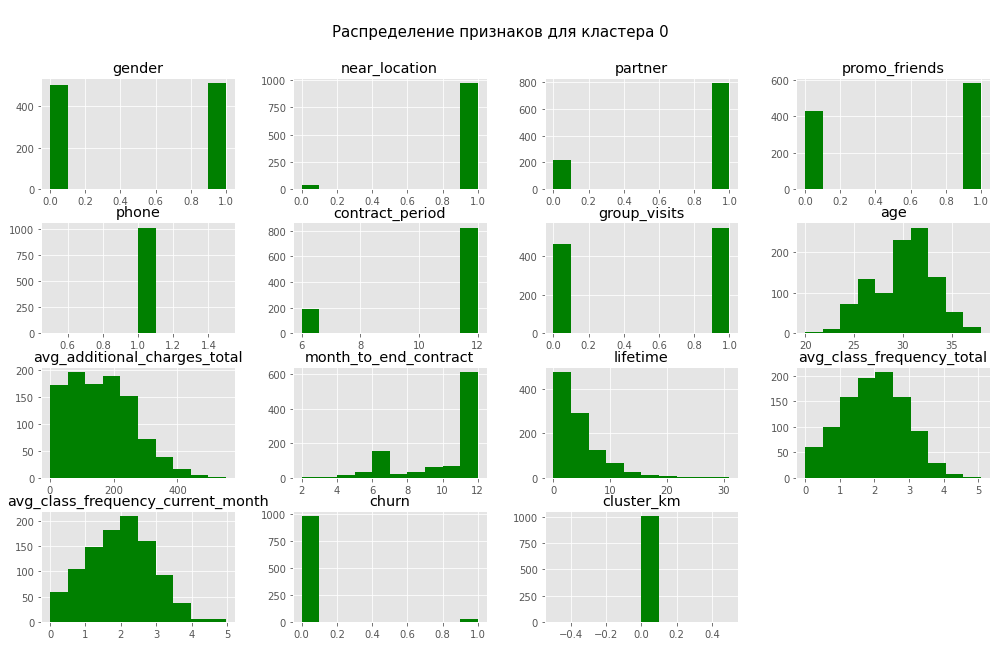

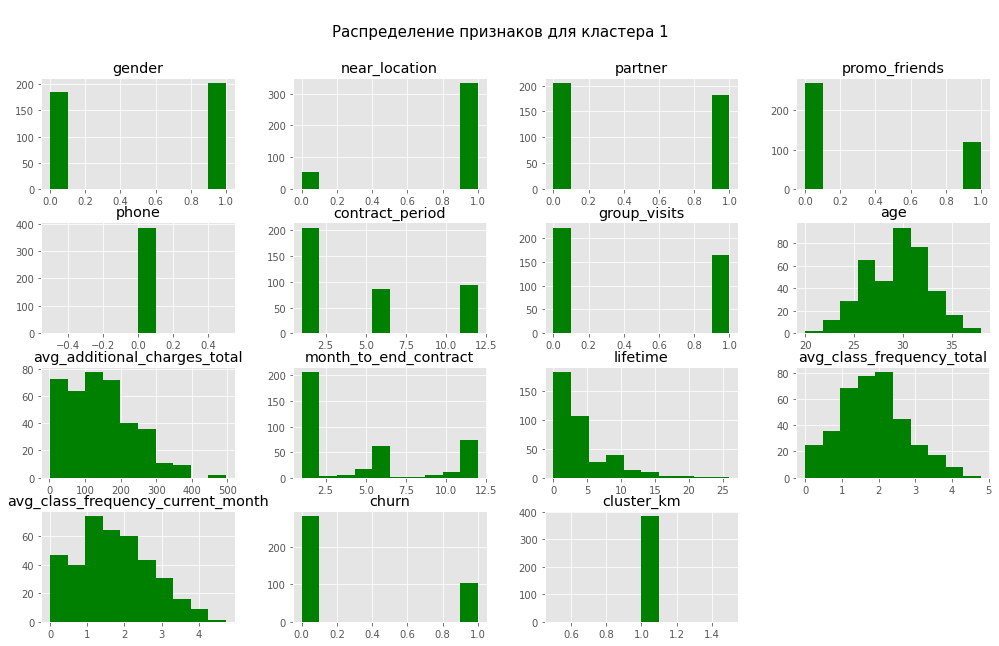

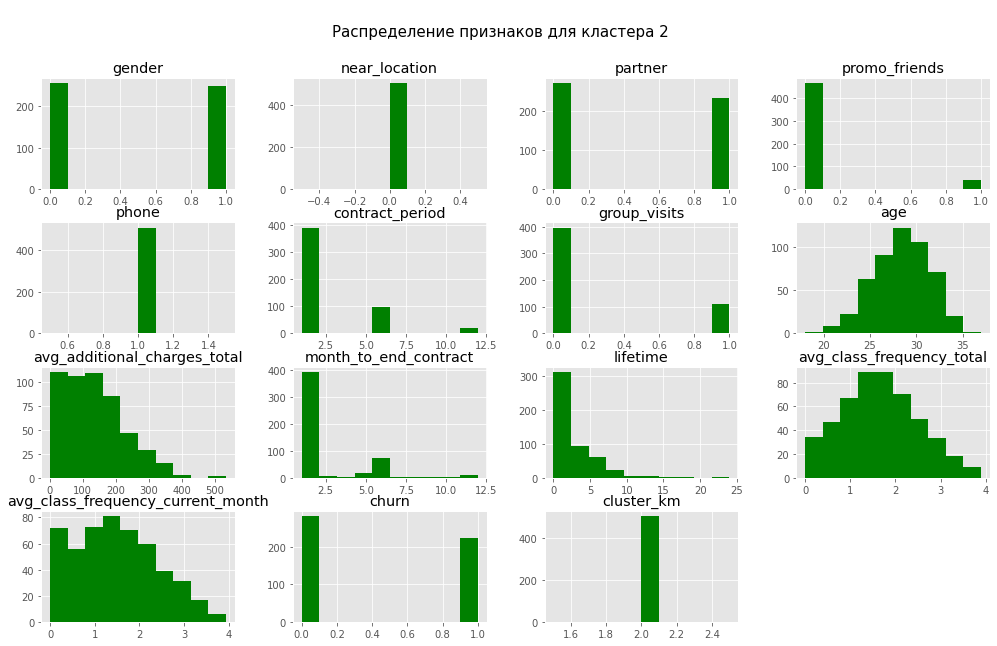

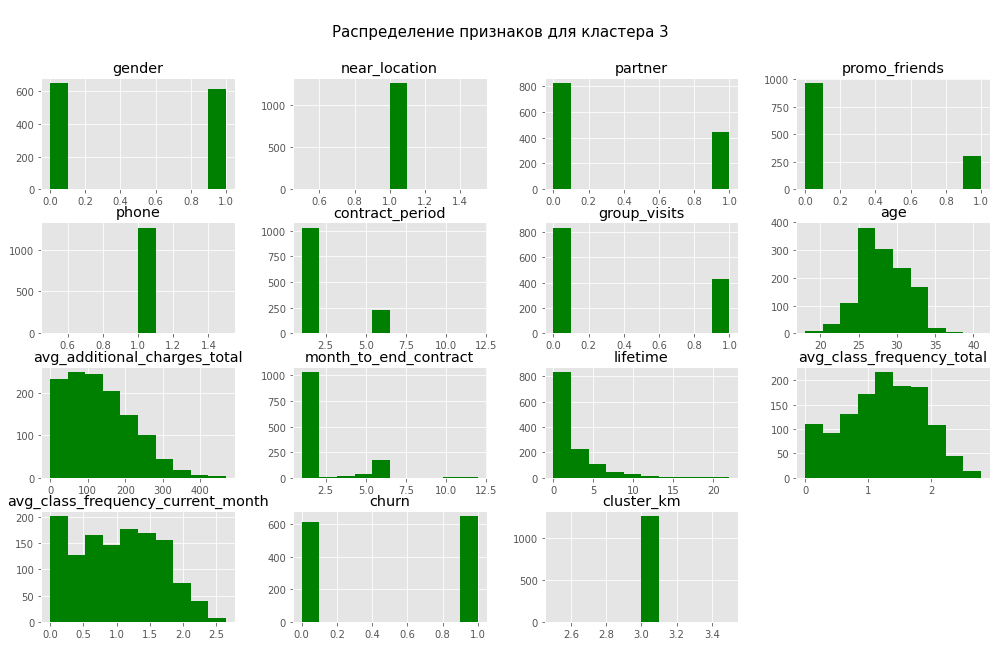

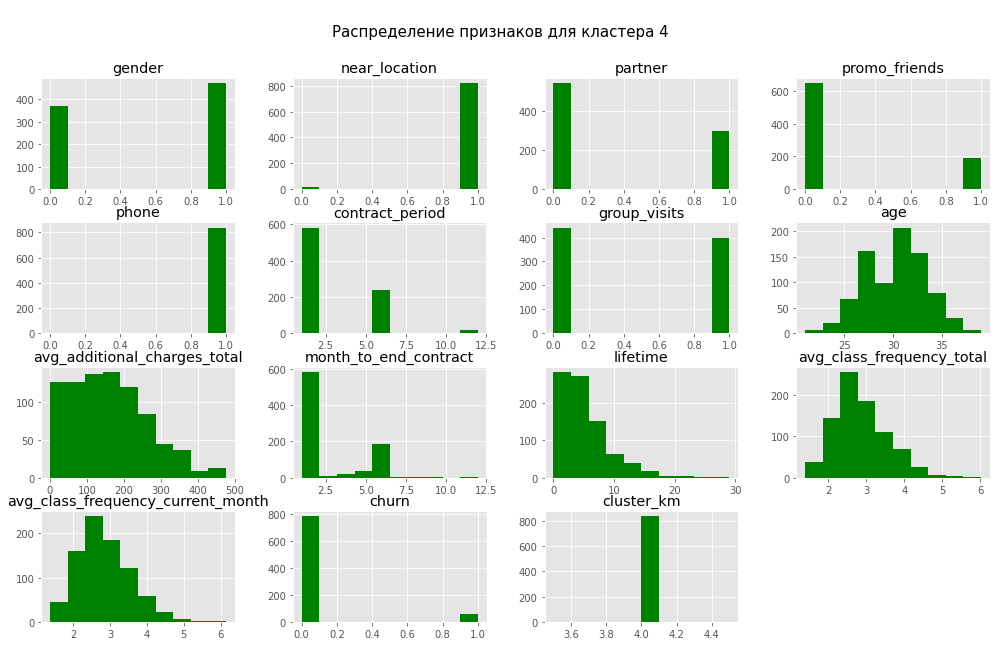

In [ ]:
df[['near_location', 'partner', 'promo_friends','group_visits', 'churn','phone','gender']] = df[['near_location', 'partner', 'promo_friends','group_visits', 'churn', 'phone','gender']].astype('int')

for value in [0, 1, 2, 3, 4]:
    df[df['cluster_km']==value].hist(figsize=(17,10), color = 'g')
    plt.suptitle('\nРаспределение признаков для кластера {}'.format(value), fontsize = 15)
    plt.show()

**Кластер 0** - Живут поблизости, много пользуются доп услугами. Больше всего контрактов на длительное время.<br>
**Кластер 1** - Преимущественно контракты на небольшой период времени.<br>
**Кластер 2** - Все проживают или работают далеко от клуба. В основном контракты на маленький период<br>
**Кластер 3** - самый "молодой" кластер, отток привышает оставшихся клиентов. Котракты на маленький период времени. Больше всего платят за доп услуги. Может только ради массажа и приходили?<br>
**Кластер 4** - Много посещений в неделю,  в основном одиночки.
<br>Посчитаем процент оттока аждого кластера от общего процента оттока.


In [ ]:
#рассчитываем процент
outflow = df.query('churn==1').groupby('cluster_km')['churn'].count() / df.query('churn==1')['churn'].count()
outflow.reset_index()


,cluster_km,churn
0,0,0.026390
1,1,0.097078
2,2,0.211122
3,3,0.611687
4,4,0.053723


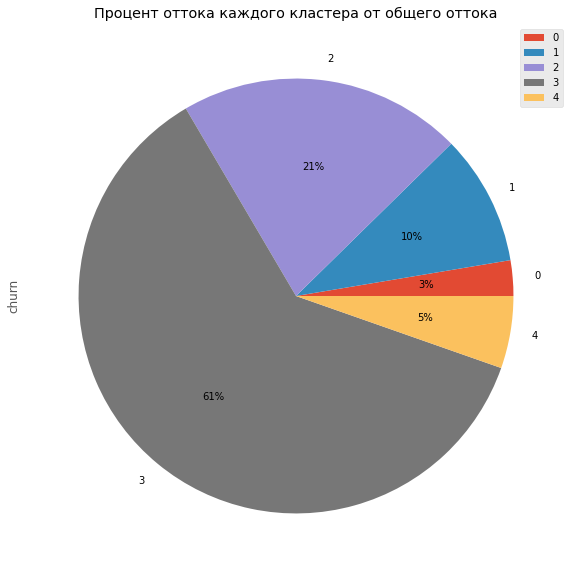

In [ ]:
#строим круговую диаграмму
plt.figure(figsize=(15, 10))
outflow.plot(kind='pie', y='churn', autopct='%.0f%%')
plt.title('Процент оттока каждого кластера от общего оттока')
plt.legend()
plt.show()

Самый большой процент оттока, как и предпологалось, у **Кластера 3** - 61%, самый маленький у **Кластера 0** всего 3%.<br>Выведем так же табличку со значениями оттока внутри кластеров

In [ ]:
flow = df.query('churn==1').groupby('cluster_km')['churn'].count() / df.groupby('cluster_km')['churn'].count()
flow

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64

У **Кластера 3** больше половины клиентов ушли в отток, а у кластера **Кластера 0** в оттоке менее 3%.

## Выводы

В ходе работы мы выделили 5 кластеров клиентов.  
  
  
**Кластер 0** 
- 2,8% отток клиентов, что  является самым маленьким. 
- Проживают рядом с клубом. 
- Большая часть ходит на групповые занятия.
- Период контракта от 6 мес, но в основном 12 мес.
- Больше половины по акции "Приведи друга"
- Около 2 посещений в неделю.<br>
Клиенты из данного кластера поддерживают свою форму, живут не далеко и это удобно. Самые постоянные клиенты.  
  
**Кластер 1** 
- 26,7% отток клиентов
- Основная часть клиентов проживает или работает рядом с фитнес-клубом.
- Нет контактных телефонов
- Самый маленький кластер - 385 клиентов.
- Контракт у основного числа клиентов на 1 мес.
- Большая часть не посещает групповые занятия.
- Около 2 посещений в неделю.<br>
Клиекты из данного кластера имеют приличный отток, их мало и они не оставили контактные номера, скорее всего это клиенты, которые решили "попробовать" походить в наш фитнес-клуб.  

 
**Кластер 2** 
- Отток около 44,3%, 
- Все проживают или работают далеко от клуба.
- Друзей в клубе так же почти ни у кого нет.
- Групповые занятия почти не посещают.
- Контракт у основного числа клиентов на 1 мес.
- Около 1-2 посещений в неделю.<br>
Самая большая проблема оттока данного кластера в том, что они проживают или работают далеко от клуба. Из-за этого не ходят часто и не посещают групповые занятия, это мешает им втянуться в занятия и остаться  внашем клубе на долго.  
  
**Кластер 3** 
- Отток 51,4%
- Самый большой кластер - 1262 клиента.
- Все проживают или работают рядом с фитнес-клубом. 
- Контракт у основного числа клиентов на 1 мес.
- Посещение в неделю 1 и с течением времени идет на спад.
- Половина клиентов посещала групповые занятия.
Больше 50% клиентов из данного кластера уходит в отток не смотря на близость проживания. Скорее всего это тот тип клиентов, которые начали жизнь с понедельника и спонтанно купили абонеммент в спорт-зал, но сделать это своей привычной не смогли.  
  
**Кластер 4** 
- 6,8% - отток.
- Основная часть клиентов живет или работает не далеко от клуба.
- Контракт у основного числа клиентов на 1 мес.
- 2-3 посещения в неделю.
- Около 40% посещают групповые занятия
Клиенты данного кластера имеют не большой отток и часто посещают наш фитнес-клуб. Скорее всего тут сосредоточены уже бывалые спортсмены, которые знают что хотят или ищут для себя новый фитнес-клуб.  
  
  
**Рекомендации**
- Т.к. у большинства кластеров преобладает покупка абонемента всего на 1 мес, необходимо пересмотреть цены на длительные абонементы, предоставить на них скидки и акции. Возможно, расширить линейку периодов абонементов и сделать абонемент на 3 и 9 месяцев, предоставлять заморозку.
- Стоит рассмотреть расширение групповых программ т.к. они пользуются популярность.
- Проводить мотивационную работу для поддержания стабильного посещения в первые несколько недель после покупки абонемента. Т.к. с течением времени количество посещений уменьшается и клиенты не успевают сделать посещение фитнес-клуба своей привычкой.
- Уделять большее внимание клиентам, которые попадают под **кластеры: 1, 2 и 3**.